In [1]:
import duckdb
import pandas as pd

# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [2]:
%%sql success_fail << 
SELECT 
    ValueInt as count, 
    Attributes['path'][1] as path, 
    Attributes['result'][1] as result,
    Attributes['method'][1] as method
    
FROM 'metrics.parquet' 
WHERE
    Name = 'goose_requests_total'
    AND Attributes['mode'][1] = 'manager'

In [3]:
pivoted = success_fail.pivot(index=['path','method'], columns=['result'], values='count')

ratios = pivoted.apply(lambda r: {'Percentage of Successful Requests': 100.0 * r.success / (r.success + r.fail)}, axis=1, result_type='expand').rename_axis(['path','method']).reset_index()
ratios

,path,method,Percentage of Successful Requests
0,setup,POST,100.000000
1,update_large_model,GET,100.000000
2,update_large_model,POST,96.594062
3,update_small_model,GET,100.000000
4,update_small_model,POST,96.589615


In [4]:
%%sql percentiles <<
SELECT 
    ValueDouble as duration, 
    Attributes['path'][1] as path,
    Attributes['percentile'][1] as percentile,
    Attributes['method'][1] as method
FROM './metrics.parquet' 
WHERE 
    Name = 'goose_requests_duration_percentiles' 
    AND Attributes['mode'][1] = 'manager' 
ORDER BY percentile

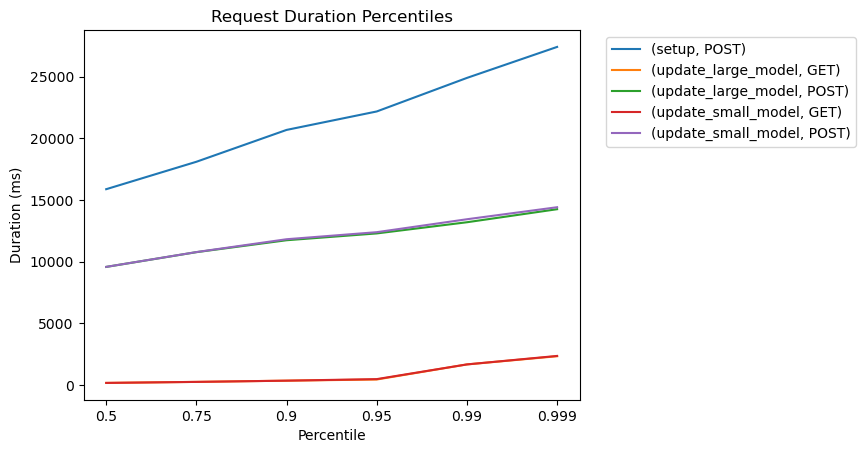

In [14]:
from matplotlib import pyplot as plt


_, ax = plt.subplots()

for label, df in percentiles.groupby(['path','method']):
    df.plot(
        x='percentile',
        y='duration',
        label=label,
        legend=True,
        logy=False,
        ax=ax,
    )

plt.title('Request Duration Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Duration (ms)')
plt.legend(bbox_to_anchor=(1.04, 1))

In [6]:
%%sql duration_df << SELECT 
    ValueInt as duration
FROM './metrics.parquet' 
WHERE 
    Name = 'goose_duration' 
    AND Attributes['mode'][1] = 'manager' 

In [7]:
duration_secs = duration_df['duration'][0]
duration_secs

600

In [8]:
%%sql req_totals <<
SELECT 
    ValueInt as total, 
    Attributes['path'][1] as path,
    Attributes['result'][1] as result,
    Attributes['method'][1] as method
FROM './metrics.parquet' 
WHERE 
    Name = 'goose_requests_total' 
    AND Attributes['mode'][1] = 'manager'

In [9]:
%%sql scenario_totals <<
SELECT 
    ValueInt as total, 
    Attributes['scenario'][1] as scenario
FROM './metrics.parquet'
WHERE 
    Name = 'goose_scenarios_total' 
    AND Attributes['mode'][1] = 'manager'

In [10]:
%%sql tx_totals <<
SELECT 
    ValueInt as total, 
    Attributes['result'][1] as result,
    Attributes['scenario'][1] as scenario,
    Attributes['tx_name'][1] as name
FROM './metrics.parquet'
WHERE 
    Name = 'goose_txs_total' 
    AND Attributes['mode'][1] = 'manager'

In [11]:
scenario_totals['reqs_per_sec'] = scenario_totals['total'] /  duration_secs
scenario_totals


,total,scenario,reqs_per_sec
0,13925,ceramic_write_only,23.208333


In [12]:
tx_totals['reqs_per_sec'] = tx_totals['total'] /  duration_secs
tx_totals

,total,result,scenario,name,reqs_per_sec
0,1000,success,ceramic_write_only,setup,1.666667
1,14416,success,ceramic_write_only,update_small_model,24.026667
2,0,fail,ceramic_write_only,update_large_model,0.000000
3,13925,success,ceramic_write_only,update_large_model,23.208333
4,0,fail,ceramic_write_only,setup,0.000000
5,0,fail,ceramic_write_only,update_small_model,0.000000


In [13]:
req_totals['reqs_per_sec'] = req_totals['total'] /  duration_secs
req_totals

,total,path,result,method,reqs_per_sec
0,14416,update_large_model,success,GET,24.026667
1,491,update_large_model,fail,POST,0.818333
2,0,setup,fail,POST,0.000000
3,13925,update_large_model,success,POST,23.208333
4,4000,setup,success,POST,6.666667
5,0,update_large_model,fail,GET,0.000000
6,14925,update_small_model,success,GET,24.875000
7,0,update_small_model,fail,GET,0.000000
8,509,update_small_model,fail,POST,0.848333
9,14416,update_small_model,success,POST,24.026667
